
# Analysis of data generated  from OSMR

https://github.com/osmr/imgclsmob





In [7]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [26]:
import numpy as np
import pandas as pd
import os, time
import datetime as dt
import itertools
import statsmodels.api as sm
from scipy.stats import kendalltau

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2020-12-31T12:06:43.294948-08:00

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



###  Helper Notebook to make Plots


In [28]:
import import_ipynb
import ModelPlots as MP

### To read the raw files generated

<pre>
pip install xlrd==1.2.0
</pre>

In [29]:
path = "./data/osmr"

In [30]:
df_all = pd.read_csv(path+"/df_all.csv")
df_all

,Unnamed: 0,modelname,check,check_compound,checkTF,checkTF_compound,norm,norm_compound,lognorm,lognorm_compound,...,sigma_mp,sigma_mp_compound,numofSpikes,numofSpikes_compound,ratio_numofSpikes,ratio_numofSpikes_compound,softrank_mp,softrank_mp_compound,logpnorm,logpnorm_compound
0,0,wrn28_10_cifar100,0.873725,0.773567,0.925764,0.812261,10.797475,10.652062,0.996938,0.988406,...,0.709364,0.667378,0.000000,0.000000,0.000000,0.000000,143.904470,138.349114,-5.428285,-5.944612
1,1,wrn28_10_svhn,0.601419,0.533661,0.449782,0.394636,6.504677,6.296168,0.783711,0.766469,...,0.722710,0.692651,0.000000,0.000000,0.000000,0.000000,336.553320,326.315932,-4.641690,-4.992451
2,2,wrn40_8_cifar10,0.532602,0.492409,0.326409,0.298103,5.558056,5.492968,0.712637,0.708339,...,0.740547,0.719379,0.000000,0.000000,0.000000,0.000000,368.470762,360.051882,-5.002736,-5.142759
3,3,wrn40_8_cifar100,0.791673,0.728488,0.952522,0.869919,8.735812,8.755586,0.900006,0.899789,...,0.718941,0.689542,0.000000,0.000000,0.000000,0.000000,173.518491,165.970009,-5.717918,-5.656400
4,4,wrn40_8_svhn,0.537902,0.495928,0.329377,0.300813,5.411185,5.329015,0.701243,0.694357,...,0.734079,0.713223,0.000000,0.000000,0.000000,0.000000,370.743275,358.604449,-4.834103,-5.031324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,306,preresnet26,1.417044,0.871028,0.799257,0.820627,8.698458,8.658644,0.905574,0.890431,...,0.921806,0.873345,2.231818,2.615079,0.016345,0.018776,0.968605,0.926630,2.539925,2.385639
307,307,preresnetbc26b,1.923161,0.399779,0.514085,0.267347,8.801484,8.730163,0.910042,0.890402,...,0.863415,0.646415,5.827957,16.544061,0.029034,0.073706,0.840359,0.610259,2.376383,2.055879
308,308,preresnet34,1.210359,0.788568,0.847507,0.860514,7.866827,7.894940,0.867597,0.860032,...,0.922045,0.883865,1.500000,1.870370,0.011611,0.014262,1.261983,1.201694,2.184712,2.098635
309,309,preresnetbc38b,1.636872,0.357473,0.591398,0.286686,8.039993,7.766750,0.872862,0.848162,...,0.856890,0.623130,4.978102,15.246612,0.023465,0.067470,1.020744,0.661828,2.001607,1.550771


In [64]:
for x in df_all.modelname.sort_values():
    if x.endswith("cub"):
        print(x)

mobilenet_w1_cub
ntsnet_cub
proxylessnas_mobile_cub
resnet10_cub
resnet12_cub
resnet14_cub
resnet16_cub
resnet18_cub
resnet26_cub
seresnet10_cub
seresnet12_cub
seresnet14_cub
seresnet16_cub
seresnet18_cub
seresnet26_cub


### Remove outliers

- EfficientNet b0 and b1
- ResNext CIFAR00 all models

In [31]:
print("before removing outliers, we have {} models".format(len(df_all)) )
bad_models = ['efficientnet_b0', 'efficientnet_b1']
bad_models.extend(['resnext272_2x32d_cifar100', 'resnext29_16x64d_cifar100','resnext29_32x4d_cifar100','resnext272_1x64d_cifar100'])
for mname in bad_models:
    df_all = df_all[df_all.modelname!=mname]
print("after removing outliers, we have {} models".format(len(df_all)) )


before removing outliers, we have 311 models
after removing outliers, we have 305 models


### Plots with Test Accuracies

- read the test accuracies directly from the IOSMR site

In [32]:
from bs4 import BeautifulSoup
import requests
import re

In [33]:
'''Load the test accuracies'''
url = "https://github.com/osmr/imgclsmob/blob/master/pytorch/README.md"
df_accuracy = pd.read_html(url)

In [34]:
'''Create the matchtable: Match the model name'''
response = requests.get(url)
page = str(BeautifulSoup(response.content, features="lxml"))

## To find the category of models to group when plotting
models = re.findall('<li>(.*) \(<a href=', page) 

## The naming convention is not very consistent, therefore, to help with identification,
## I input the exceptions
exceptions = {'SqueezeNext': 'SqNxt', 'DIA-ResNet': 'DIA-PreResNet', 
              'DarkNet Ref/Tiny/19': 'DarkNet Tiny', 
              'IBN-ResNet/IBN-ResNeXt/IBN-DenseNet': 'IBN(b)-ResNet'} 
models_ = [m if m not in exceptions.keys() else m+'/'+exceptions[m] for m in models]
models_ = [m.split('/') for m in models_]

## Use reg exp to extract the dataset name, modelnames (used in README), and 
## modelnames (used in codes)
datasets = re.findall('<h3><a aria-hidden="true" class="anchor" href="#(.*)" id', page)
lst1_name = re.findall('<tr>\n<td>(.*)</td>', page)
lst2_name = re.findall('\n<td>.* \(<a href="(.*)">log</a>\)</td>\n</tr>', page)

if len(lst1_name) != len(lst2_name):
    print('Number does not match!')

df_table = pd.DataFrame(lst1_name, columns = ['Model'])

## Note: there are duplicate Model names, hence cannot use merge naively
df_table['modelname'] = [m.split('/')[-1][:-22] for m in lst2_name]

In [35]:
'''Identify the architexture for each pretrained model'''
class ContinueI(Exception):
    pass

continue_i = ContinueI()

arch = []
for i in range(len(df_table)):
    try:
        for mm in models_:
            for m1 in mm:
                ## Name convention 1: the model name starts with the arch name
                if df_table.loc[i, 'Model'].startswith(m1): 
                    arch.append(mm)
                    raise continue_i
        try:
            ## Name convention 2: if the model name starts with number, 
            ## the arch name is in the middle of the model name
            this = re.findall('[0-9]+-(.*)', df_table.loc[i, 'Model'])[0]
        except:
            arch.append(np.nan)
            raise continue_i

        for mm in models_:
            for m1 in mm:
                if this.startswith(m1):
                    arch.append(mm)

                    raise continue_i

        arch.append(np.nan)

    except ContinueI:
        continue

df_table['group'] = arch
df_table['group'] = df_table['group'].apply(lambda x: '/'.join(x))

In [169]:
df_table

,Model,modelname,group
0,AlexNet,alexnet,AlexNet
1,AlexNet-b,alexnetb,AlexNet
2,ZFNet,zfnet,ZFNet
3,ZFNet-b,zfnetb,ZFNet
4,VGG-11,vgg11,VGG/BN-VGG
...,...,...,...
555,SimplePose(Mobile),simplepose_mobile_mobilenetv3_small_w1_coco,SimplePose
556,SimplePose(Mobile),simplepose_mobile_mobilenetv3_large_w1_coco,SimplePose
557,Lightweight OpenPose 2D,lwopenpose2d_mobilenet_cmupan_coco,Lightweight OpenPose
558,Lightweight OpenPose 3D,lwopenpose3d_mobilenet_cmupan_coco,Lightweight OpenPose


In [36]:
'''Match the model name using matchtable'''
# df_all = pd.read_excel(path + '/df_all.xlsx').rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
df_all['spectralnormlog'] = np.log(df_all['spectralnorm'])

df_full = []
i = 0

for df in df_accuracy:
    # Because there are duplicate Model names (on README), you cannot
    # simply use merge
    df = df.copy()
    df['modelname'] = df_table.loc[i:i+len(df)-1, 'modelname'].tolist()#temp[i:i+len(df)]
    df['group'] = df_table.loc[i:i+len(df)-1, 'group'].tolist()
    i += len(df)

    del df['Remarks']

    df = df.merge(df_all, on = 'modelname', how = 'left')

    df_full.append(df)

df_full = dict(zip(datasets, df_full))

In [37]:
df_full['imagenet-1k']

,Model,Top1,Top5,Params,FLOPs/2,modelname,group,Unnamed: 0,check,check_compound,...,sigma_mp_compound,numofSpikes,numofSpikes_compound,ratio_numofSpikes,ratio_numofSpikes_compound,softrank_mp,softrank_mp_compound,logpnorm,logpnorm_compound,spectralnormlog
0,AlexNet,38.50,16.64,62378344,"1,132.33M",alexnet,AlexNet,50.0,6.312063,1.803071,...,0.724677,39.181818,93.934603,0.221105,0.142307,0.123766,0.121950,3.811582,3.626827,4.701469
1,AlexNet-b,39.74,17.47,61100840,714.83M,alexnetb,AlexNet,51.0,5.415376,1.641999,...,0.743370,32.581818,96.579048,0.224065,0.145615,0.151018,0.130632,3.551809,3.467992,4.389939
2,ZFNet,39.79,17.27,62357608,"1,170.33M",zfnet,ZFNet,52.0,4.725841,1.786327,...,0.719677,40.036364,92.902857,0.225115,0.144605,0.108592,0.113837,4.081376,3.739922,4.345286
3,ZFNet-b,36.37,14.90,107627624,"2,479.13M",zfnetb,ZFNet,53.0,5.037417,1.844308,...,0.650784,63.672727,132.488889,0.265277,0.182669,0.063393,0.074588,4.095295,3.805100,4.512583
4,VGG-11,29.90,10.36,132863336,"7,615.87M",vgg11,VGG/BN-VGG,54.0,1.943881,1.474718,...,0.757683,31.818182,87.777778,0.132913,0.131504,0.196762,0.169916,3.634474,3.530661,3.256282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,ResNet(A)-101b,19.78,5.03,44568392,"8,072.93M",resneta101b,ResNet,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,ResNet(A)-152b,19.62,4.82,60212040,"11,796.83M",resneta152b,ResNet,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,ResNet(D)-50b,21.04,5.65,25680808,"20,497.60M",resnetd50b,ResNet,247.0,0.734454,0.317371,...,0.583746,7.703518,24.818182,0.037639,0.093492,1.185150,0.684582,1.803401,1.385736,1.449708
304,ResNet(D)-101b,19.59,4.73,44672936,"35,392.65M",resnetd101b,ResNet,248.0,0.518111,0.222608,...,0.540957,4.624352,15.430818,0.022697,0.061941,1.952303,1.016048,0.886480,0.387835,0.874076


In [67]:
df_full['cub-200-2011']

,Model,"Error, %",Params,FLOPs/2,modelname,group,Unnamed: 0,check,check_compound,checkTF,...,sigma_mp_compound,numofSpikes,numofSpikes_compound,ratio_numofSpikes,ratio_numofSpikes_compound,softrank_mp,softrank_mp_compound,logpnorm,logpnorm_compound,spectralnormlog
0,ResNet-10,27.77,5008392,893.63M,resnet10_cub,ResNet,115,0.833250,0.395363,0.424000,...,0.489566,0.0,0.0,0.0,0.0,732.482953,659.980036,-9.437806,-9.959246,-3.417594
1,ResNet-12,27.27,5082376,"1,125.84M",resnet12_cub,ResNet,116,0.725372,0.372030,0.314685,...,0.524564,0.0,0.0,0.0,0.0,648.961700,606.072883,-7.832884,-8.724490,-3.607538
2,ResNet-14,24.77,5377800,"1,357.53M",resnet14_cub,ResNet,117,0.612102,0.325685,0.204969,...,0.553269,0.0,0.0,0.0,0.0,815.039900,764.947657,-8.497868,-9.352935,-3.929778
3,ResNet-16,23.65,6558472,"1,588.93M",resnet16_cub,ResNet,118,0.506545,0.281597,0.184358,...,0.578787,0.0,0.0,0.0,0.0,1101.589820,1029.090493,-8.965352,-11.101516,-4.250425
4,ResNet-18,23.33,11279112,"1,820.00M",resnet18_cub,ResNet,119,0.449721,0.252917,0.172589,...,0.603118,0.0,0.0,0.0,0.0,1023.471933,991.849978,-8.606751,-8.936038,-4.472972
5,ResNet-26,23.16,17549832,"2,746.38M",resnet26_cub,ResNet,120,0.398146,0.238577,0.133829,...,0.654806,0.0,0.0,0.0,0.0,1089.868542,1013.301292,-7.595067,-7.667442,-4.557194
6,SE-ResNet-10,27.72,5052932,893.86M,seresnet10_cub,SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,121,0.710078,0.243378,0.300752,...,0.490595,0.0,0.0,0.0,0.0,806.432777,665.193077,-8.954819,-9.164494,-3.678435
7,SE-ResNet-12,26.51,5127496,"1,126.17M",seresnet12_cub,SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,122,0.628034,0.226707,0.241830,...,0.525532,0.0,0.0,0.0,0.0,685.046568,601.952239,-8.350411,-8.717309,-3.820963
8,SE-ResNet-14,24.16,5425104,"1,357.92M",seresnet14_cub,SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,123,0.579189,0.210430,0.225434,...,0.554325,0.0,0.0,0.0,0.0,649.105857,585.216404,-8.138262,-8.384182,-3.939207
9,SE-ResNet-16,23.32,6614240,"1,589.35M",seresnet16_cub,SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,124,0.528541,0.194415,0.176166,...,0.578927,0.0,0.0,0.0,0.0,692.778599,627.225633,-8.034735,-8.718680,-4.082659


In [161]:
for dataset, df in df_full.items():
    print(dataset, len(df))

imagenet-1k 306
cifar-10 70
cifar-100 68
svhn 63
cub-200-2011 15
pascal-voc20102 4
ade20k 6
cityscapes 6
coco-semantic-segmentation 4
celebamask-hq 1
coco-keypoints-detection 17


### Plots

In [38]:
'''[SETUP CELL] Start Plotting'''
metrics = ['alpha', 'alpha_weighted', 'spectralnormlog', 'softrank', 'norm', 'norm_compound' ] #specify the ww matrics
metrics_acc = ['Top1', 'Top5', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

metrics = ['alpha', 'alpha_weighted', 'spectralnormlog',  'softranklog',  'lognorm' ,'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy


### By Dataset, Metric (all models for each dataset)

Dataset imagenet-1k ['Top1']  11


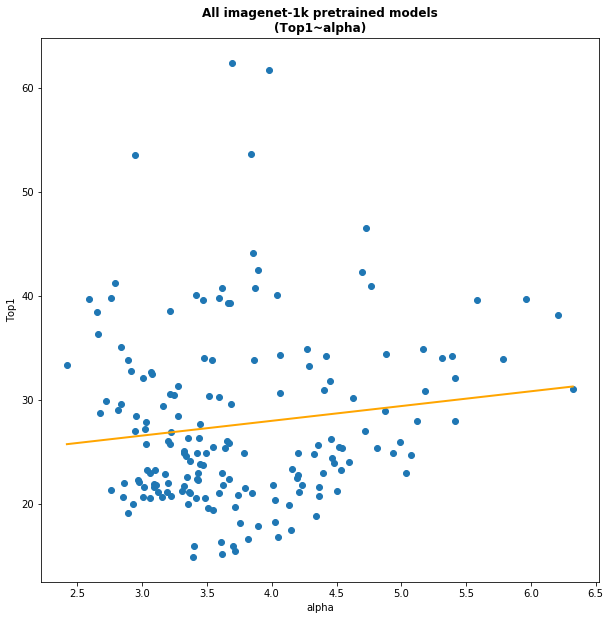

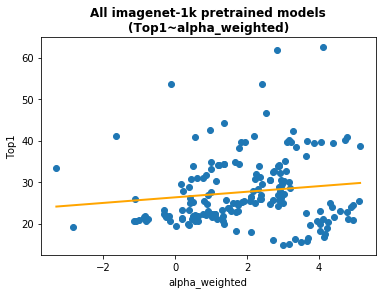

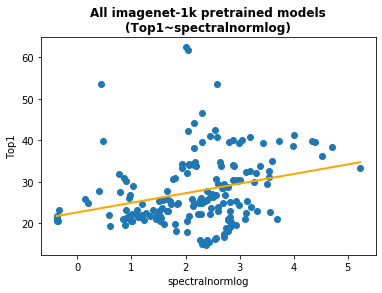

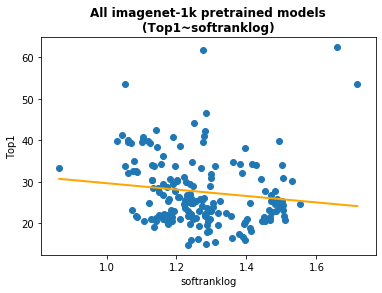

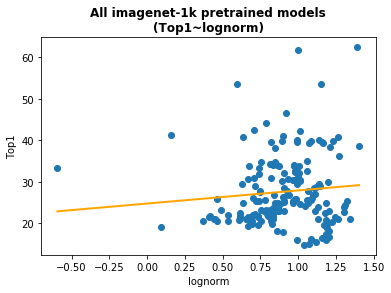

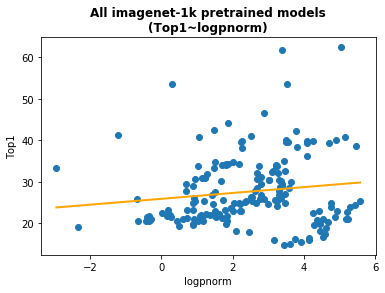

Dataset cifar-10 ['Error, %']  8


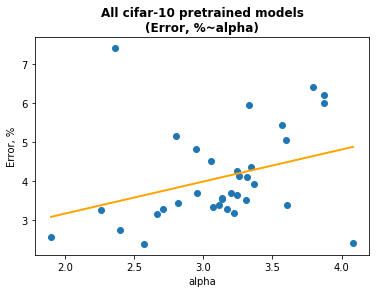

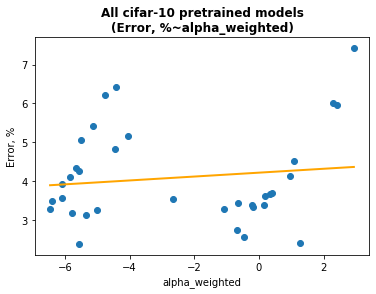

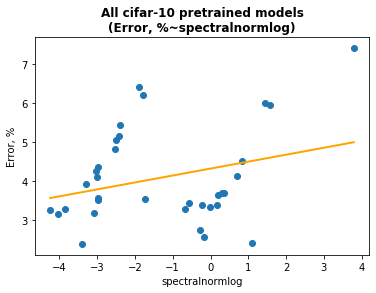

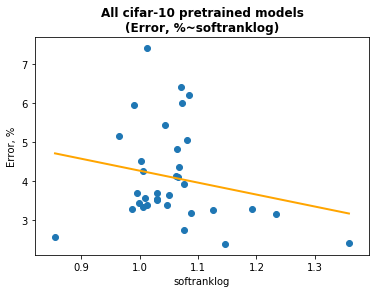

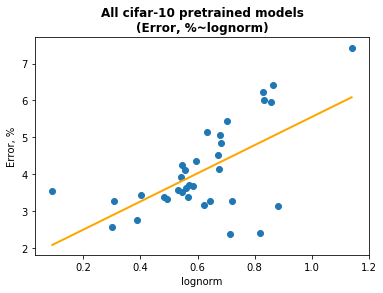

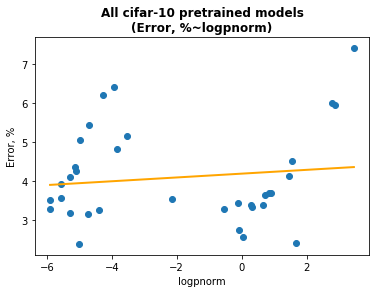

Dataset cifar-100 ['Error, %']  9


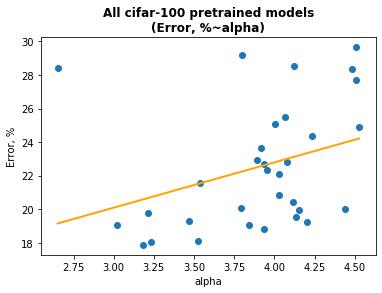

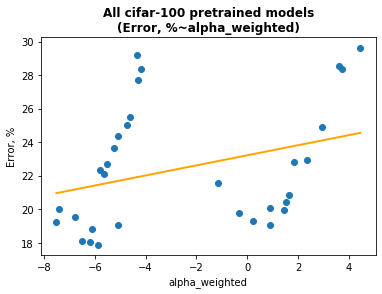

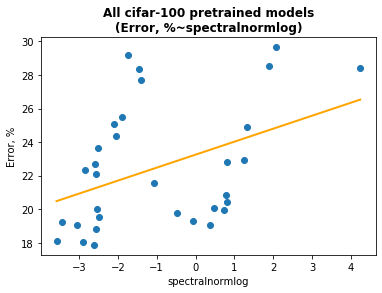

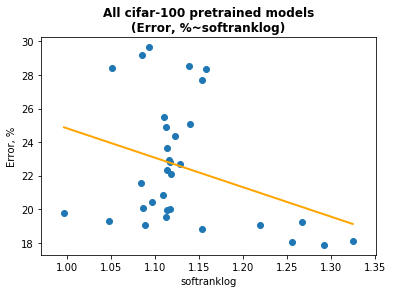

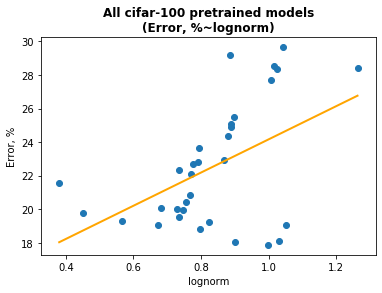

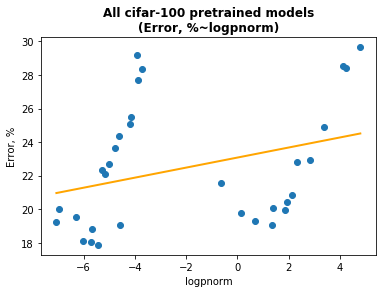

Dataset svhn ['Error, %']  4


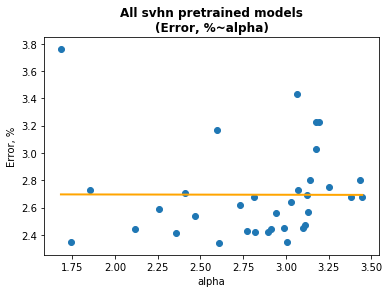

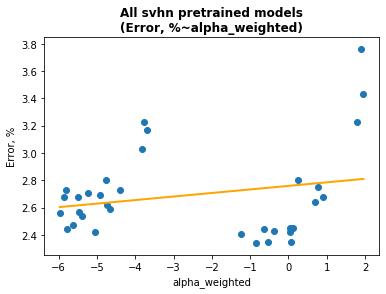

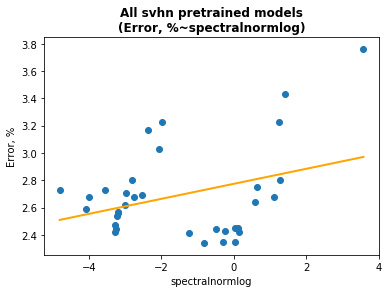

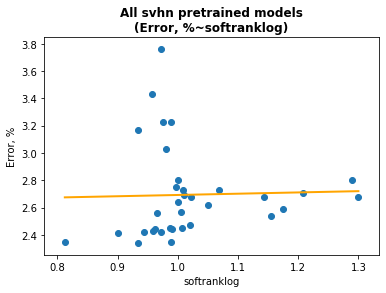

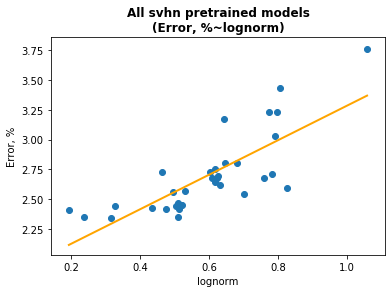

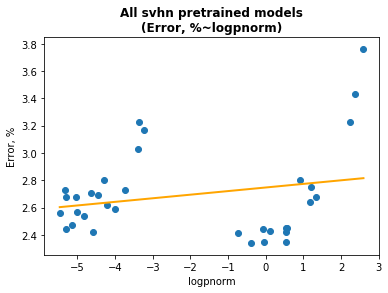

Dataset cub-200-2011 ['Error, %']  12


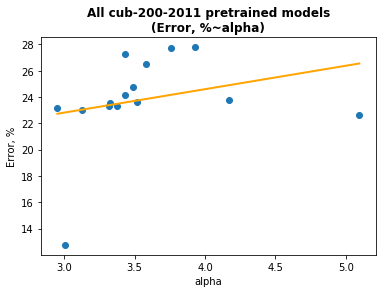

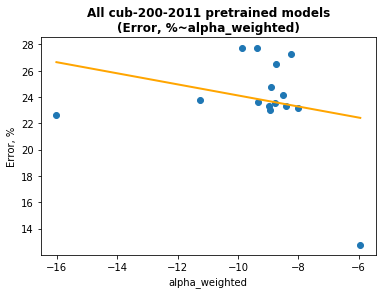

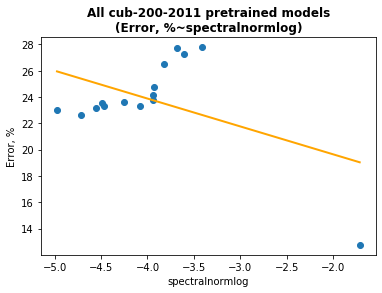

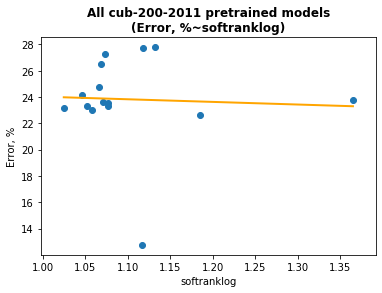

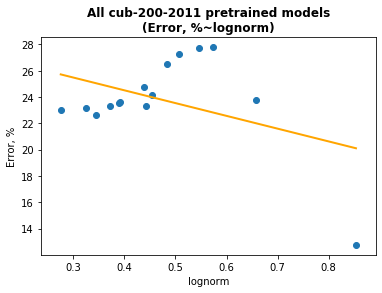

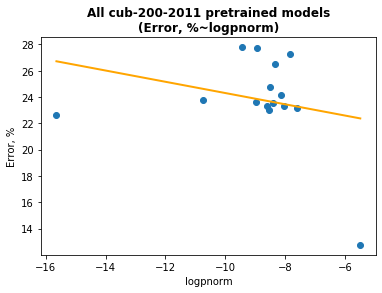

Dataset pascal-voc20102 ['Pix.Acc.,%', 'mIoU,%']  15


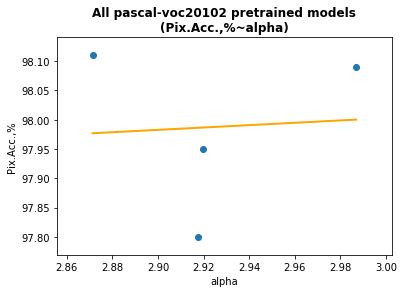

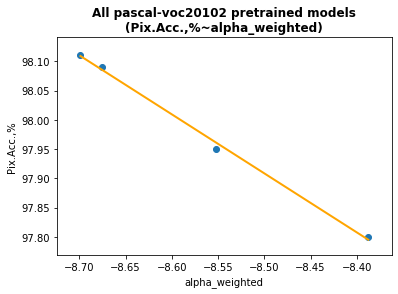

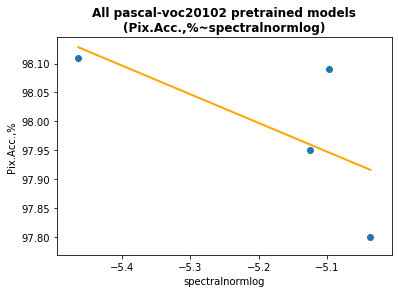

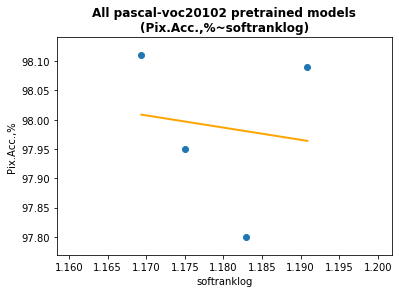

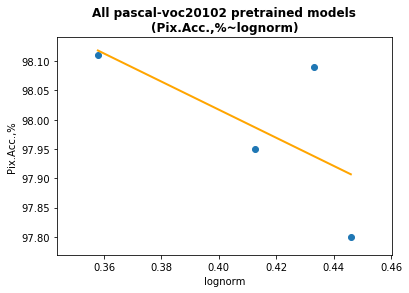

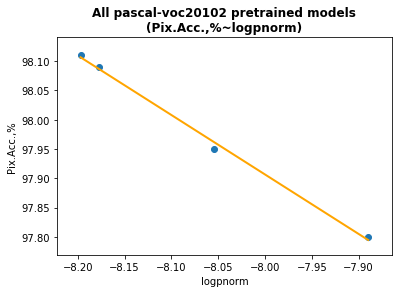

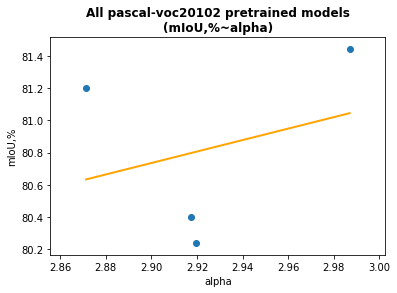

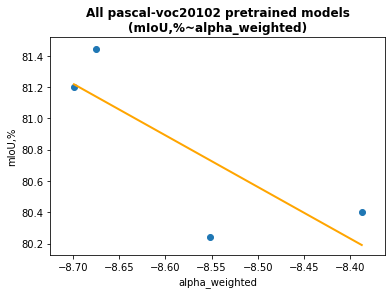

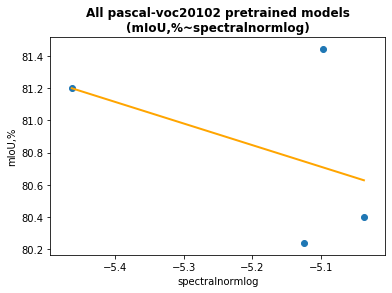

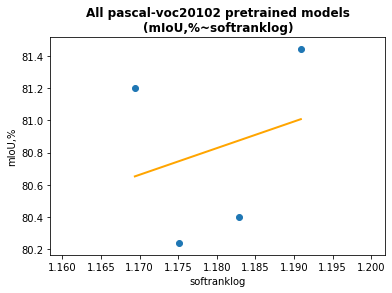

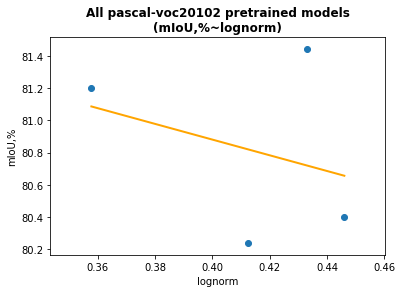

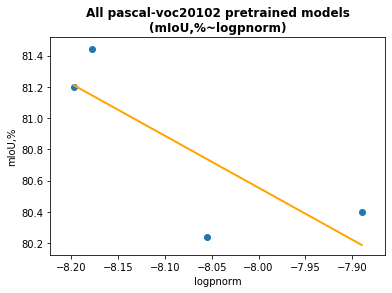

Dataset ade20k ['Pix.Acc.,%', 'mIoU,%']  6


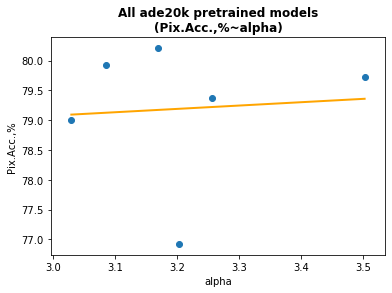

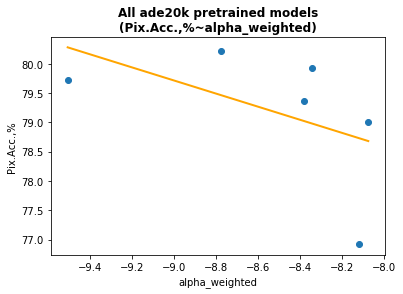

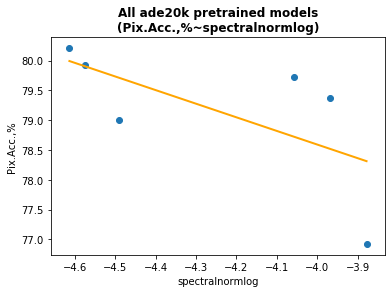

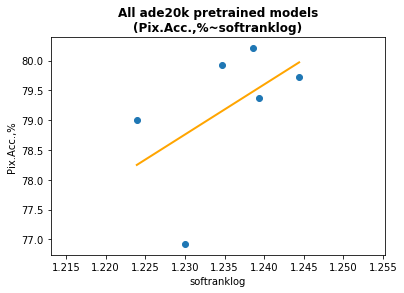

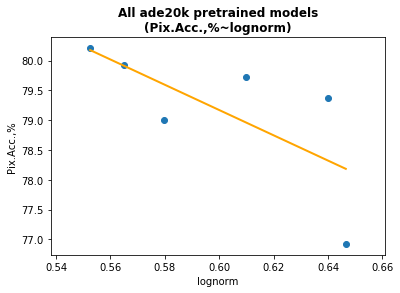

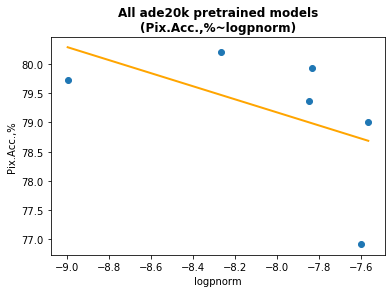

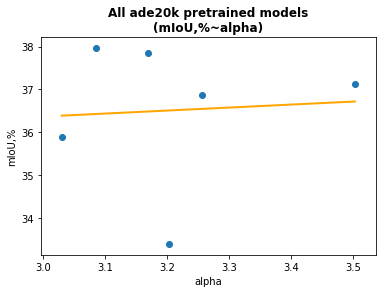

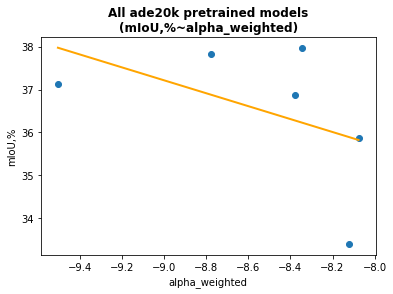

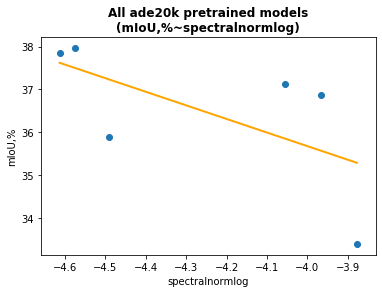

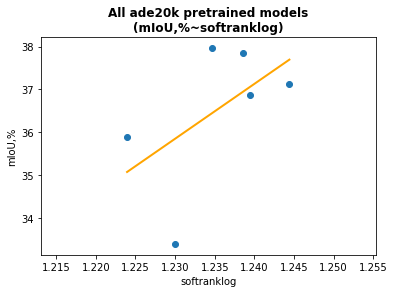

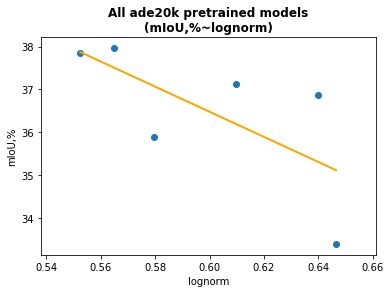

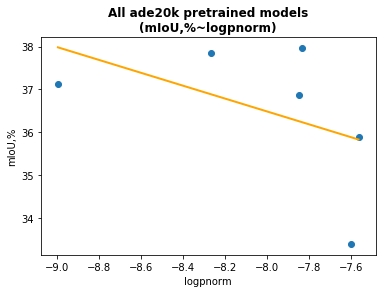

Dataset cityscapes ['Pix.Acc.,%', 'mIoU,%']  10


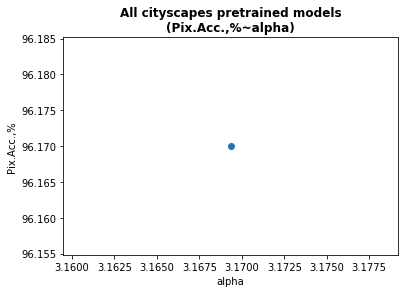

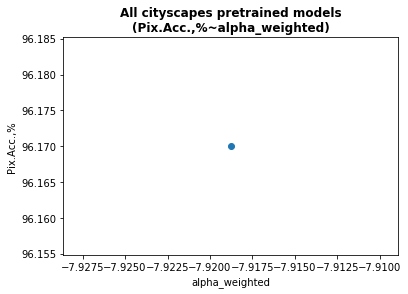

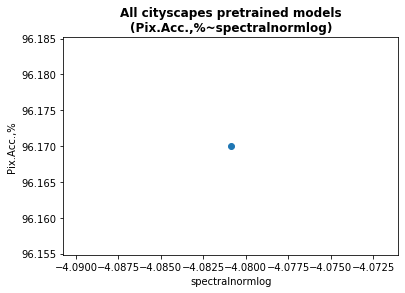

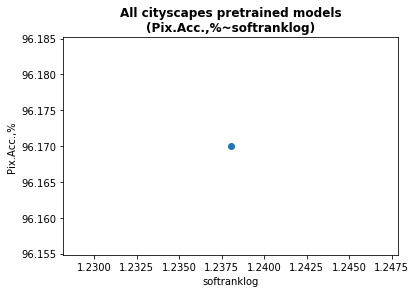

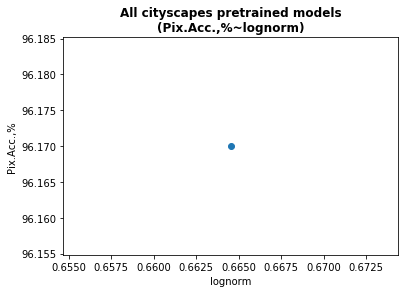

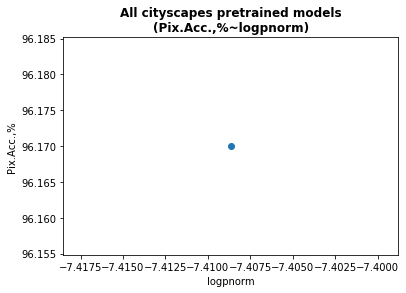

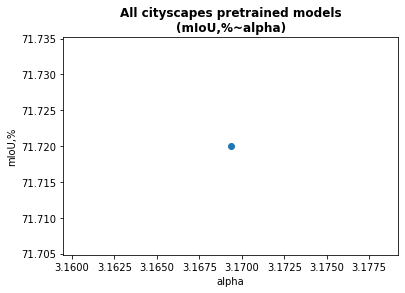

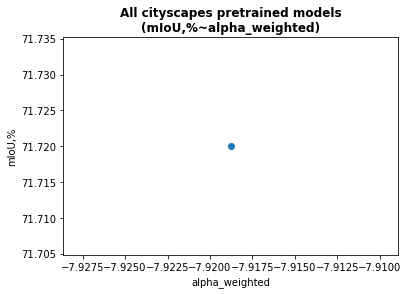

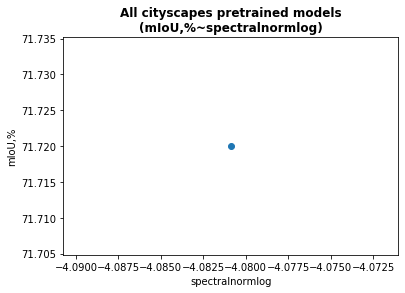

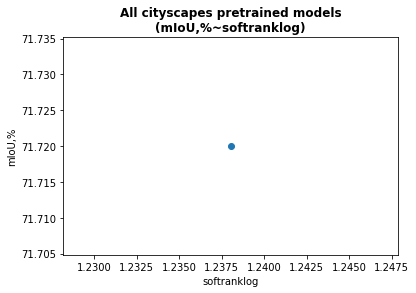

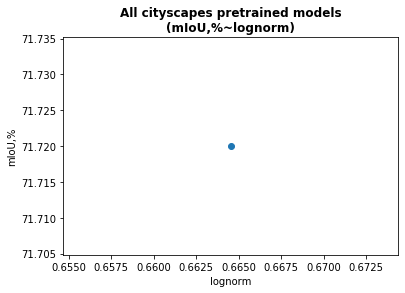

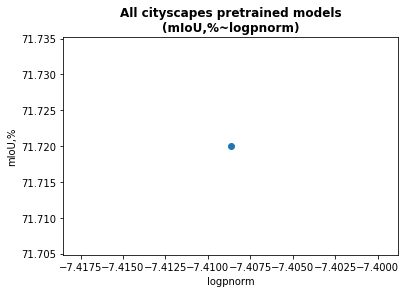

Dataset coco-semantic-segmentation ['Pix.Acc.,%', 'mIoU,%']  26


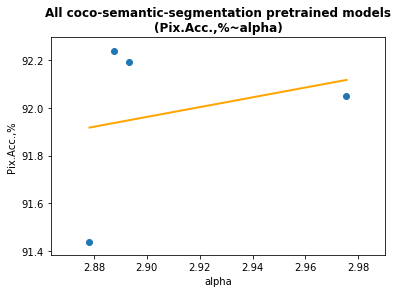

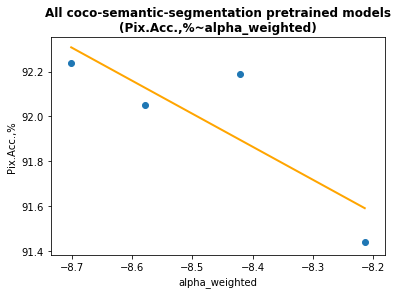

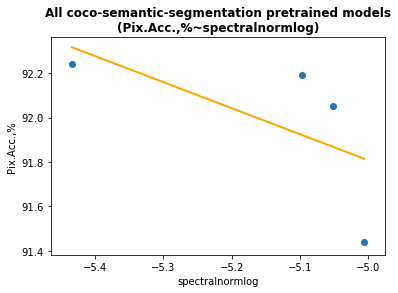

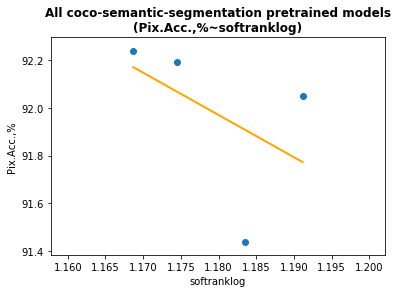

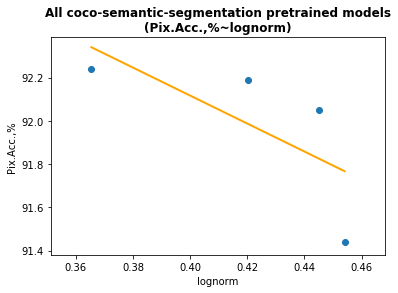

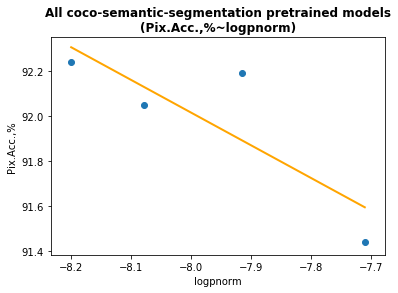

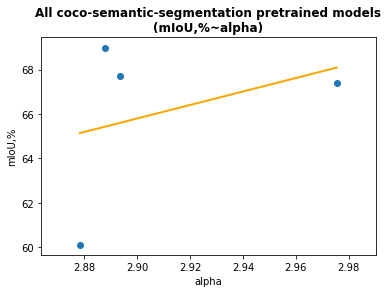

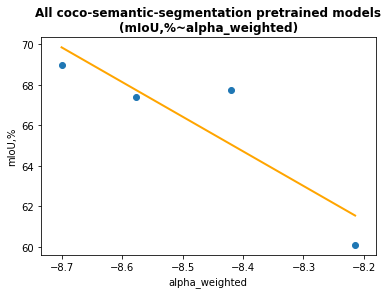

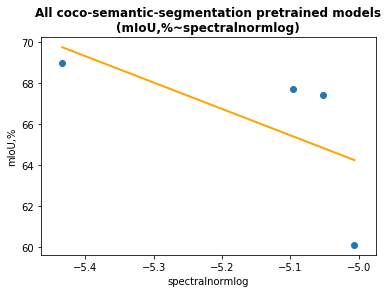

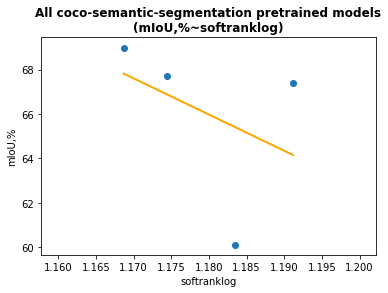

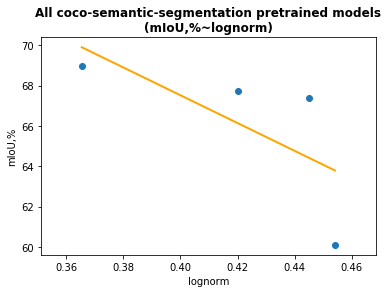

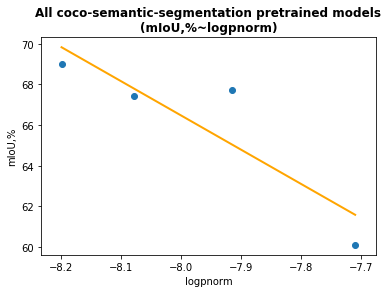

Dataset coco-keypoints-detection []  24


ValueError: 6 columns passed, passed data had 5 columns

In [39]:
plot_fit = True
plt.figure(figsize = (10,10))

    
'''Plotting by datasets'''
df_fit0 = []

for d in datasets:
    temp = df_full[d].copy()
    if len(temp) == 1:
        continue

    tacc = [c for c in metrics_acc if c in temp.columns]
    print("Dataset {} {}  {}".format(d,tacc, len(d)))
          
    try:
        for ac in tacc:
            for x in metrics:
                plt.scatter(temp[x], temp[ac])
                plt.xlabel(x)
                plt.ylabel(ac)
                plt.title('All {} pretrained models\n({}~{})'.format(d, ac, x), 
                        fontweight = 'bold')

                if plot_fit == True:
                    temp = temp.dropna().reset_index(drop = True)
                    this_fit = sm.OLS(temp[ac], sm.add_constant(temp[x].to_numpy())).fit()
                    this_x = np.linspace(min(temp[x]), max(temp[x]), 1000)
                    plt.plot(this_x, this_fit.predict(sm.add_constant(this_x)), linewidth = 2, color = 'orange')
                    df_fit0.append([d, ac, x, this_fit.ssr/len(temp), this_fit.rsquared])
                plt.show()
    except e:
        print(e)
        pass


del temp
del tacc

if df_fit0 != []:
    df_fit0 = pd.DataFrame(df_fit0, columns = ['dataset', 'test accuracy', 'x variable', 'MSE', 'r^2', ''])

##  Fit a linear regression for each Architecture Series, Dataset


1. Plots
2. df_fit (next cell): records the X, Y, degree, SSE and MSE for the fit'''


- Compute  RMSE, R2, and Kendal-Tau statisitics


In [98]:
datasets

['imagenet-1k',
 'cifar-10',
 'cifar-100',
 'svhn',
 'cub-200-2011',
 'pascal-voc20102',
 'ade20k',
 'cityscapes',
 'coco-semantic-segmentation',
 'celebamask-hq',
 'coco-keypoints-detection']

### We have a lot more models than we started with, but we don't use them all here

In [230]:
valid_datasets = {}
min_num_models = 4
for d in datasets:
    df = df_full[d].copy()
    df.dropna(inplace=True)

    model_counts = df['group'].value_counts().to_frame()
    model_counts = model_counts[model_counts.group >=  min_num_models]
    if (len(model_counts) > 0):
        valid_datasets[d] = len(model_counts)
        display(model_counts)

,group
ResNet,22
EfficientNet,20
PreResNet,14
VGG/BN-VGG,12
ShuffleNet,12
DLA,10
HRNet,9
DRN-C/DRN-D,7
SqueezeNext/SqNxt,6
ESPNetv2,5


,group
DIA-ResNet/DIA-PreResNet,8
ResNet,8
ResNet,8
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,5


,group
DIA-ResNet/DIA-PreResNet,8
ResNet,8
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,5
ResNet,8
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,5
WRN,4


,group
DIA-ResNet/DIA-PreResNet,8
ResNet,7
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,4
ResNeXt,4
ResNet,7
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,4
ResNeXt,4
WRN,4


,group
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt,6
ResNet,6


### Valid Datasets for the paper (>= 4 models)

In [231]:
valid_datasets

{'imagenet-1k': 13,
 'cifar-10': 3,
 'cifar-100': 4,
 'svhn': 5,
 'cub-200-2011': 2}

In [279]:
import warnings
import re

metrics = [  'lognorm' ,'spectralnormlog',  'alpha_weighted' , 'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

metric_name = {'lognorm':'LogFrob', 'spectralnormlog':'LogSpecNorm',  'alpha_weighted':'AlphaHat' , 'logpnorm':'LogAlphaNorm'}

this_deg = 1

min_num_models = 4

table6_counts = {}
table6new_counts = {}


df_fit = []
for d in datasets:
    print(d)
    df = df_full[d].copy()
    df.dropna(inplace=True)

    this_groups = df['group'].value_counts().to_frame()

    table6new_counts[d] = {}

    for g in this_groups[this_groups['group'] >= min_num_models].index:

        this_group = df[df['group'] == g].copy()
        this_group = this_group.dropna().reset_index(drop = True)
        n = len(this_group) #size
        
        table6new_counts[d][g] = n 
        if g in table6_counts:
            table6_counts[g] = table6_counts[g] + n
        else:
            table6_counts[g] = n


        tacc = [c for c in metrics_acc if c in this_group.columns]

        for ac in tacc:
            #print("Dataset {} Group {} Metric  {}".format(d,tacc, len(d)))

            for x in metrics:
                plt.figure(figsize = (5,5))

                # fix modelname for figures
                short_g = g.split("/")[0] #
                short_g = short_g.split("\\")[0] 

                title = '{} {} {}'.format(d, short_g, metric_name[x])
                figname = "./img/omsr_{}_{}_{}.png".format(d, short_g, x).replace("-","_")
                    
                try:
                    1/0
                    for i in range(len(this_group)):
                        plt.scatter(this_group.loc[i,x], this_group.loc[i, ac], label = this_group.loc[i, 'modelname'], c='b')
                                        
                    
                    plt.xlabel(metric_name[x])
                    plt.ylabel(ac)

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")  

                        this_fit = sm.OLS(this_group[ac], sm.add_constant( this_group[x] )).fit()
                        coef = this_fit.params[x] 
                        this_x = np.linspace(min(this_group[x]), max(this_group[x]), 50)

                        plt.plot(this_x, this_fit.predict(sm.add_constant(this_x))) ##coef[0]*this_x**2 + coef[1]*this_x + coef[2]) 
                        this_sse = this_fit.ssr 
                        this_rsquared = this_fit.rsquared

                        ktau, pvsl = kendalltau(this_group[x] ,this_group[ac])

                        this_arch = [d, g, ac, x, this_deg, n, this_rsquared, this_sse, this_sse/n, ktau]
                        rmse = np.sqrt(this_sse/n)
                        title += " \nRMSE={:03.2f}  R2={:03.2f} Ktau={:03.2f} ".format(rmse, this_rsquared, ktau)


                        plt.title(title, fontweight = 'bold')
                        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #this_group['Model']
                    print("save to "+figname)
                    plt.savefig(figname)
                    plt.show()

                                         

                except np.linalg.LinAlgError: #does not converge
                    print("{} did not converge {}".format(d))
                    this_arch = [d, g, ac, x, this_deg, n, 'Not converge', np.nan, np.nan, np.nan]

                    
                except:
                    pass
                         
                df_fit.append(this_arch)
                
                
                

imagenet-1k
cifar-10
cifar-100
svhn
cub-200-2011
pascal-voc20102
ade20k
cityscapes
coco-semantic-segmentation
celebamask-hq
coco-keypoints-detection


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [114]:
df_fit = pd.DataFrame(df_fit, columns = ['Dataset', 'Archtecture', 'Test Accuracy', 
                                          'x Variable', 'Poly Degree','# of Models', 
                                         'r^2', 'SSE', 'MSE',  'Ktau'])

print("number of records {}".format(len(df_fit)))
df_fit.dropna(inplace=True)

del this_groups
del this_group
del this_x
del this_sse

print("number of records {}".format(len(df_fit)))

number of records 108
number of records 108


In [119]:
df_fit.head()

,Dataset,Archtecture,Test Accuracy,x Variable,Poly Degree,# of Models,r^2,SSE,MSE,Ktau
0,imagenet-1k,ResNet,Top1,lognorm,1,22,0.791801,140.259464,6.375430,0.774892
1,imagenet-1k,ResNet,Top1,spectralnormlog,1,22,0.634307,246.359828,11.198174,0.740260
2,imagenet-1k,ResNet,Top1,alpha_weighted,1,22,0.880575,80.453881,3.656995,0.878788
3,imagenet-1k,ResNet,Top1,logpnorm,1,22,0.864433,91.328418,4.151292,0.878788
4,imagenet-1k,EfficientNet,Top1,lognorm,1,20,0.651727,53.484190,2.674210,0.673684


In [120]:
for x in ['r^2', 'MSE', 'Ktau']:
    temp = df_fit.copy()
    print(len(temp))
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp.describe()
    display(summary)
    print('===============================================')

del df_fitp

108
108
For r^2:


x Variable,alpha_weighted,lognorm,logpnorm,spectralnormlog
count,27.000000,27.000000,27.000000,27.000000
mean,0.683030,0.666834,0.685014,0.598259
std,0.254206,0.305703,0.258883,0.334921
min,0.083627,0.005399,0.076199,0.000602
25%,0.478576,0.593980,0.515740,0.367372
50%,0.738633,0.707967,0.745447,0.647078
75%,0.890593,0.925918,0.877609,0.901194
max,0.979183,0.985519,0.989105,0.962670


108
108
For MSE:


x Variable,alpha_weighted,lognorm,logpnorm,spectralnormlog
count,27.000000,27.000000,27.000000,27.000000
mean,3.013681,4.466908,2.779356,9.673783
std,5.157539,8.828369,5.012522,23.491736
min,0.002421,0.001684,0.002322,0.003125
25%,0.069389,0.099987,0.073486,0.100774
50%,0.404478,0.363396,0.477335,0.511909
75%,3.125359,3.400413,2.798186,6.817349
max,19.537656,35.379455,18.480655,89.579949


108
108
For Ktau:


x Variable,alpha_weighted,lognorm,logpnorm,spectralnormlog
count,27.000000,27.000000,27.000000,27.000000
mean,0.644686,0.655000,0.640993,0.518118
std,0.349338,0.312297,0.345569,0.449613
min,-0.333333,-0.333333,-0.333333,-0.666667
25%,0.591270,0.533333,0.608586,0.380952
50%,0.714286,0.673684,0.688889,0.666667
75%,0.873460,0.861905,0.873460,0.815873
max,1.000000,1.000000,1.000000,1.000000


### Table 3:  to be updated

In [124]:
pd.options.display.float_format = '{:,.3f} '.format
for x in ['r^2', 'MSE', 'Ktau']:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp[['lognorm', 'spectralnormlog', 'alpha_weighted', 'logpnorm']].describe()
    display(summary.loc[['mean', 'std']])
    print('===============================================')

del df_fitp

108
For r^2:


x Variable,lognorm,spectralnormlog,alpha_weighted,logpnorm
mean,0.667,0.598,0.683,0.685
std,0.306,0.335,0.254,0.259


108
For MSE:


x Variable,lognorm,spectralnormlog,alpha_weighted,logpnorm
mean,4.467,9.674,3.014,2.779
std,8.828,23.492,5.158,5.013


108
For Ktau:


x Variable,lognorm,spectralnormlog,alpha_weighted,logpnorm
mean,0.655,0.518,0.645,0.641
std,0.312,0.450,0.349,0.346


## Tables 5 and 6

- updated , but need to double check all results

In [241]:
table6_counts

{'ResNet': 51,
 'EfficientNet': 20,
 'PreResNet': 14,
 'VGG/BN-VGG': 12,
 'ShuffleNet': 12,
 'DLA': 10,
 'HRNet': 9,
 'DRN-C/DRN-D': 7,
 'SqueezeNext/SqNxt': 6,
 'ESPNetv2': 5,
 'SqueezeNet/SqueezeResNet': 4,
 'IGCV3': 4,
 'ProxylessNAS': 4,
 'DIA-ResNet/DIA-PreResNet': 24,
 'SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt': 20,
 'WRN': 8,
 'ResNeXt': 4}

#### sorted by name

In [282]:
for k, v in sorted(table6_counts.items()):
    print("{} & {} \\\\".format(k,v))

DIA-ResNet/DIA-PreResNet & 24 \\
DLA & 10 \\
DRN-C/DRN-D & 7 \\
ESPNetv2 & 5 \\
EfficientNet & 20 \\
HRNet & 9 \\
IGCV3 & 4 \\
PreResNet & 14 \\
ProxylessNAS & 4 \\
ResNeXt & 4 \\
ResNet & 51 \\
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt & 20 \\
ShuffleNet & 12 \\
SqueezeNet/SqueezeResNet & 4 \\
SqueezeNext/SqNxt & 6 \\
VGG/BN-VGG & 12 \\
WRN & 8 \\


#### sorted by values

In [278]:
sorted_by_counts = sorted(table6_counts.items(), key=lambda x: x[1], reverse=True)
for k,v in sorted_by_counts:
    print("{} & {} \\\\".format(k,v))

ResNet & 51 \\
DIA-ResNet/DIA-PreResNet & 24 \\
EfficientNet & 20 \\
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt & 20 \\
PreResNet & 14 \\
VGG/BN-VGG & 12 \\
ShuffleNet & 12 \\
DLA & 10 \\
HRNet & 9 \\
WRN & 8 \\
DRN-C/DRN-D & 7 \\
SqueezeNext/SqNxt & 6 \\
ESPNetv2 & 5 \\
SqueezeNet/SqueezeResNet & 4 \\
IGCV3 & 4 \\
ProxylessNAS & 4 \\
ResNeXt & 4 \\


#### Could also have dataset

In [306]:
for g in table6_counts.keys():
    for d in valid_datasets:
        if g not in table6new_counts[d]:
            table6new_counts[d][g] = 0
            
        

'imagenet-1k & cifar-10 & cifar-100 & svhn & cub-200-2011 \\\\'

In [328]:
ds = [k for k in valid_datasets.keys()]
ds[0], ds[1], ds[2], ds[3], ds[4]
header = "{} & {} &{} & {} & {} & {} & {} \\\\".format(" ", "total", ds[0], ds[1], ds[2], ds[3], ds[4])

print(header)

for g in table6_counts.keys():
    vs = [table6new_counts[d][g] for d in valid_datasets]
    line = "{} & {} &{} & {} & {} & {} & {} \\\\".format(g, np.sum(vs), vs[0], vs[1], vs[2], vs[3], vs[4])
    print(line)

  & total &imagenet-1k & cifar-10 & cifar-100 & svhn & cub-200-2011 \\
ResNet & 51 &22 & 8 & 8 & 7 & 6 \\
EfficientNet & 20 &20 & 0 & 0 & 0 & 0 \\
PreResNet & 14 &14 & 0 & 0 & 0 & 0 \\
VGG/BN-VGG & 12 &12 & 0 & 0 & 0 & 0 \\
ShuffleNet & 12 &12 & 0 & 0 & 0 & 0 \\
DLA & 10 &10 & 0 & 0 & 0 & 0 \\
HRNet & 9 &9 & 0 & 0 & 0 & 0 \\
DRN-C/DRN-D & 7 &7 & 0 & 0 & 0 & 0 \\
SqueezeNext/SqNxt & 6 &6 & 0 & 0 & 0 & 0 \\
ESPNetv2 & 5 &5 & 0 & 0 & 0 & 0 \\
SqueezeNet/SqueezeResNet & 4 &4 & 0 & 0 & 0 & 0 \\
IGCV3 & 4 &4 & 0 & 0 & 0 & 0 \\
ProxylessNAS & 4 &4 & 0 & 0 & 0 & 0 \\
DIA-ResNet/DIA-PreResNet & 24 &0 & 8 & 8 & 8 & 0 \\
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt & 20 &0 & 5 & 5 & 4 & 6 \\
WRN & 8 &0 & 0 & 4 & 4 & 0 \\
ResNeXt & 4 &0 & 0 & 0 & 4 & 0 \\


## Weekend TODO:  

- Rebuild all tables 5 and 6 using actual models computed
- rerun some data locally using ww0.4, without push (imagenet models)
- rerun colab notebooks from Serena using ww0.2.7 and ww0.4 and save data in new places
 - (similar to WW notebook, but on colab and local)
 
- updat all notebooks with code version
- fix code, upgrade to ww0.4.1 for paper
